In [80]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import shap
import torch.nn as nn

from train import train, test
from sklearn.model_selection import train_test_split
from ldl.data import get_episodic_loader
from ldl.data.customer import get_dataset
from ldl.models import RNDModel
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [20]:
np.random.seed(3)

customer = get_dataset()

customer_train = customer.iloc[:6031]
customer_test = customer.iloc[6031:]

customer_train_torch = torch.tensor(customer_train.drop(columns=['target']).values, dtype=torch.float32)
y_train = torch.tensor(customer_train['target'].values)
customer_test_torch = torch.tensor(customer_test.drop(columns=['target']).values, dtype=torch.float32)
y_test = torch.tensor(customer_test['target'].values)

inds = np.random.permutation(customer_train_torch.shape[0])
samples_train = list(zip(customer_train_torch[inds], y_train[inds]))
samples_test = list(zip(customer_test_torch, y_test))

In [341]:
dataset = 'customer'
way = 2
train_shot = 1200
test_shot = 500
mse_loss = nn.MSELoss(reduction='none')
trials = 1
epochs = 1
silent = True
split = 'train'
add_rotations = False
in_alphabet = False
x_dim = 41
z_dim = 2000
c = 1
optimizer = 'adam'
lr = 1e-05
initialization = 'xavier_normal'
gpu = 2

device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")

In [342]:
model = RNDModel(way, in_dim=x_dim, out_dim=z_dim, opt=optimizer,
                 lr=lr, initialization=initialization)#, dld=dld)
model.to(device)

In [343]:
train(model, loss_func=mse_loss, train_loader=samples_train, epochs=epochs,
      silent=False, device=device)

Train Epoch: 1 [0/6031 (0%)]	Loss: 8.479777
Train Epoch: 1 [100/6031 (2%)]	Loss: 29.799536
Train Epoch: 1 [200/6031 (3%)]	Loss: 30.580549
Train Epoch: 1 [300/6031 (5%)]	Loss: 26.309353
Train Epoch: 1 [400/6031 (7%)]	Loss: 8.826086
Train Epoch: 1 [500/6031 (8%)]	Loss: 19.313129
Train Epoch: 1 [600/6031 (10%)]	Loss: 28.087805
Train Epoch: 1 [700/6031 (12%)]	Loss: 19.022846
Train Epoch: 1 [800/6031 (13%)]	Loss: 5.776276
Train Epoch: 1 [900/6031 (15%)]	Loss: 5.682871
Train Epoch: 1 [1000/6031 (17%)]	Loss: 38.333771
Train Epoch: 1 [1100/6031 (18%)]	Loss: 42.352448
Train Epoch: 1 [1200/6031 (20%)]	Loss: 21.052864
Train Epoch: 1 [1300/6031 (22%)]	Loss: 7.167139
Train Epoch: 1 [1400/6031 (23%)]	Loss: 0.240438
Train Epoch: 1 [1500/6031 (25%)]	Loss: 3.584263
Train Epoch: 1 [1600/6031 (27%)]	Loss: 37.064766
Train Epoch: 1 [1700/6031 (28%)]	Loss: 9.542103
Train Epoch: 1 [1800/6031 (30%)]	Loss: 1.348743
Train Epoch: 1 [1900/6031 (32%)]	Loss: 0.157028
Train Epoch: 1 [2000/6031 (33%)]	Loss: 0.212222


In [344]:
accuracy_o2m = test(model, samples_test, silent=silent, device=device)

In [345]:
accuracy_o2m

0.7752247752247752

### Logreg

In [311]:
logreg = LogisticRegression()

In [312]:
logreg.fit(customer_train.drop(columns=['target']), customer_train['target'])

/nfs/home/iglukhov/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [313]:
accuracy_score(customer_test['target'].values, logreg.predict(customer_test.drop(columns=['target'])))

0.8081918081918081

### feature importances

In [314]:
feat_mean_weight = {}
for k in model.predictors.keys():

    params = []
    for name, param in model.predictors['class_0'].named_parameters():
        params.append(param)

    np_params_w = torch.tensor(params[0]).cpu().numpy()
    np_params_b = torch.tensor(params[1]).cpu().numpy()

    feat_mean_weight[k] = np_params_w.sum(axis=0)

<ipython-input-314-1794565041d6>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  np_params_w = torch.tensor(params[0]).cpu().numpy()
<ipython-input-314-1794565041d6>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  np_params_b = torch.tensor(params[1]).cpu().numpy()


In [340]:
np_params_w.shape

(1000, 41)

In [315]:
feat_mean_weight['class_0']

array([-2.2201028 , -0.8779499 , -0.6036719 ,  1.2516596 ,  6.4598227 ,
       -1.0800003 , -0.3707913 ,  3.8421052 , -0.21222216, -0.195796  ,
       -1.918729  ,  2.1760402 ,  0.7779923 ,  3.276273  ,  0.75920343,
       -2.9100428 , -0.8321053 ,  0.2146434 , -1.7973647 ,  0.46493262,
       -3.9075015 , -1.2484593 , -1.0783309 , -1.5819851 , -2.1932263 ,
       -2.405542  , -1.1326358 , -5.4585767 , -5.0722437 , -0.38744995,
       -4.0824246 ,  0.7816019 , -2.3374655 ,  3.4639735 ,  1.6862136 ,
        2.001897  , -3.2179227 , -3.6552835 , -3.2758298 , -4.0568705 ,
       -3.3336997 ], dtype=float32)

In [316]:
feat_mean_weight_overall = np.abs(feat_mean_weight['class_0'] + feat_mean_weight['class_1'])

In [317]:
customer_test_no_target = customer_test.drop(columns=['target'])
cols = customer_test_no_target.columns
importances_o2m = {}
for i,v in enumerate(feat_mean_weight_overall):
    importances_o2m[cols[i]] = v

In [318]:
np_params_w.shape

(1000, 41)

### importance comparison

In [319]:
# get importance
plt.figure(figsize=(20, 15))
weights = np.abs(logreg.coef_[0])
# summarize feature importance
customer_test_no_target = customer_test.drop(columns=['target'])
cols = customer_test_no_target.columns
importances = {}
for i,v in enumerate(weights):
    importances[cols[i]] = v
for k in sorted(importances, key=importances.get, reverse=True):
    print(k, importances[k])

Contract_Two year 0.7281629136886518
TotalCharges 0.6811324428661713
Contract_Month-to-month 0.619076790075967
PaperlessBilling 0.37576140454837087
InternetService_Fiber optic 0.36127506718294267
InternetService_DSL 0.36050970027701723
PaymentMethod_Electronic check 0.2627921332882113
TechSupport_No 0.22999197429056353
TechSupport_Yes 0.22922660738461983
MultipleLines_No 0.22608645100586588
PhoneService_Yes 0.22563314878848506
OnlineSecurity_No 0.2051413130783767
OnlineSecurity_Yes 0.20437594617243576
SeniorCitizen 0.19951396557559237
PaymentMethod_Credit card (automatic) 0.16356476403651593
PhoneService_No 0.1321887237365762
MultipleLines_No phone service 0.1321887237365762
Dependents 0.12884300524945627
PaymentMethod_Mailed check 0.12002714832811355
StreamingTV_Yes 0.09515528321937279
OnlineBackup_No 0.09514080934523199
StreamingTV_No 0.09438991631343145
OnlineBackup_Yes 0.09437544243928594
InternetService_No 0.0942097919578348
OnlineSecurity_No internet service 0.0942097919578348
On

<Figure size 1440x1080 with 0 Axes>

In [320]:
for k in sorted(importances_o2m, key=importances_o2m.get, reverse=True):
    print(k, importances_o2m[k])

tenure 12.919645
TechSupport_Yes 10.917153
StreamingTV_No 10.144487
StreamingTV_Yes 8.164849
PaymentMethod_Electronic check 8.113741
OnlineBackup_No internet service 7.815003
TotalCharges 7.6842103
PaymentMethod_Bank transfer (automatic) 7.310567
StreamingMovies_Yes 6.927947
PaymentMethod_Mailed check 6.6673994
InternetService_DSL 6.552546
PaymentMethod_Credit card (automatic) 6.5516596
Contract_Two year 6.4358454
InternetService_No 5.8200855
TechSupport_No 4.811084
StreamingMovies_No internet service 4.674931
gender 4.4402056
DeviceProtection_Yes 4.3864527
MultipleLines_No phone service 4.3520803
Contract_One year 4.003794
MultipleLines_No 3.837458
OnlineSecurity_Yes 3.5947294
Contract_Month-to-month 3.3724272
DeviceProtection_No internet service 3.1639702
Dependents 2.5033193
OnlineBackup_Yes 2.4969187
TechSupport_No internet service 2.2652717
PaperlessBilling 2.1600006
DeviceProtection_No 2.1566617
SeniorCitizen 1.7558998
OnlineSecurity_No 1.6642106
StreamingMovies_No 1.5632038
Mult

In [321]:
norm_o2m = [float(i)/sum(feat_mean_weight_overall) for i in feat_mean_weight_overall]
norm_logreg = [float(i)/sum(weights) for i in weights]

<ipython-input-322-9a485b8e2e71>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


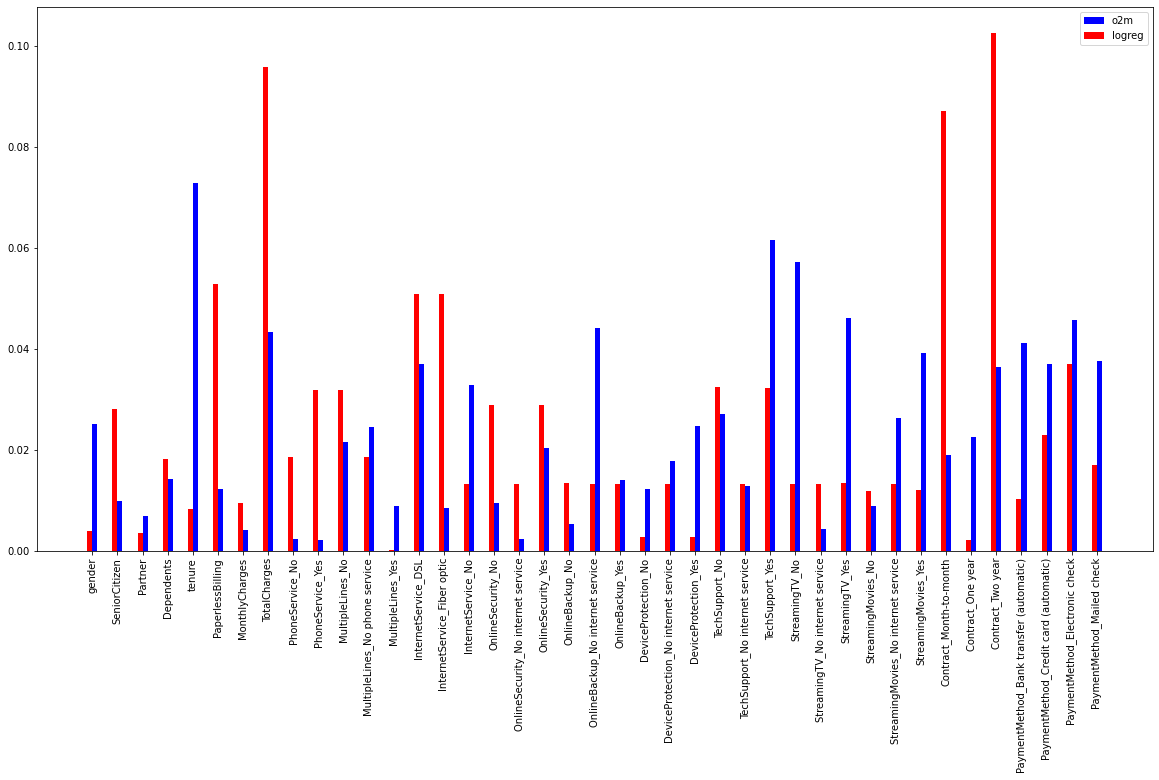

In [322]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
ax = plt.subplot(111)
ax.set_xticks(np.arange(len(weights)))
ax.bar(np.arange(len(norm_o2m))+0.1, norm_o2m, width=0.2, color='b', align='center', label='o2m')
ax.bar(np.arange(len(norm_logreg))-0.1, norm_logreg, width=0.2, color='r', align='center', label='logreg')
ax.set_xticklabels([cols[x] for x in range(len(weights))])
ax.legend()
plt.show()


### test top 5 top 10 features

In [332]:
logreg_top2 = sorted(importances, key=importances.get, reverse=True)[:2]
o2m_top2 = sorted(importances_o2m, key=importances_o2m.get, reverse=True)[:2]
logreg_top5 = sorted(importances, key=importances.get, reverse=True)[:5]
o2m_top5 = sorted(importances_o2m, key=importances_o2m.get, reverse=True)[:5]
logreg_top10 = sorted(importances, key=importances.get, reverse=True)[:10]
o2m_top10 = sorted(importances_o2m, key=importances_o2m.get, reverse=True)[:10]

In [327]:
logreg_top5

['Contract_Two year',
 'TotalCharges',
 'Contract_Month-to-month',
 'PaperlessBilling',
 'InternetService_Fiber optic']

In [328]:
o2m_top5

['tenure',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_Yes',
 'PaymentMethod_Electronic check']

In [337]:
test_logreg = LogisticRegression()
test_logreg.fit(customer_train[logreg_top2], customer_train['target'])

test_o2m = LogisticRegression()
test_o2m.fit(customer_train[o2m_top2], customer_train['target'])
accuracy_logreg = accuracy_score(customer_test['target'].values, test_logreg.predict(customer_test[logreg_top2]))
accuracy_o2m = accuracy_score(customer_test['target'].values, test_o2m.predict(customer_test[o2m_top2]))
print(f"Logreg top 2: {round(accuracy_logreg, 3)}, o2m top 2: {round(accuracy_o2m, 3)}")

Logreg top 2: 0.729, o2m top 2: 0.768


In [335]:
test_logreg = LogisticRegression()
test_logreg.fit(customer_train[logreg_top5], customer_train['target'])

test_o2m = LogisticRegression()
test_o2m.fit(customer_train[o2m_top5], customer_train['target'])
accuracy_logreg = accuracy_score(customer_test['target'].values, test_logreg.predict(customer_test[logreg_top5]))
accuracy_o2m = accuracy_score(customer_test['target'].values, test_o2m.predict(customer_test[o2m_top5]))
print(f"Logreg top 5: {round(accuracy_logreg, 3)}, o2m top 5: {round(accuracy_o2m, 3)}")

Logreg top 5: 0.789, o2m top 5: 0.779


In [338]:
test_logreg = LogisticRegression()
test_logreg.fit(customer_train[logreg_top10], customer_train['target'])

test_o2m = LogisticRegression()
test_o2m.fit(customer_train[o2m_top10], customer_train['target'])
accuracy_logreg = accuracy_score(customer_test['target'].values, test_logreg.predict(customer_test[logreg_top10]))
accuracy_o2m = accuracy_score(customer_test['target'].values, test_o2m.predict(customer_test[o2m_top10]))
print(f"Logreg top 10: {round(accuracy_logreg, 3)}, o2m top 10: {round(accuracy_o2m, 3)}")

Logreg top 10: 0.795, o2m top 10: 0.786


/nfs/home/iglukhov/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [331]:
test_logreg = LogisticRegression()
logreg.fit(customer_train[o2m_top5], customer_train['target'])
accuracy_score(customer_test['target'].values, logreg.predict(customer_test[o2m_top5]))

0.7792207792207793